In [1]:
import pandas as pd
import numpy as np
import os
import csv
import ast
import matplotlib.pyplot as plt
from collections import Counter
import geopandas as gpd
import h5py
from datetime import datetime, timedelta
import sys
sys.path.append("../Codes/")
# import mobility as mbl
from python_mobility import mobility_matrix_extract_modzcta as mm
from python_mobility import parameters as mp
from python_mobility import analysis as ma
from matplotlib.colors import TwoSlopeNorm, LogNorm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

my package for mobility extraction has been imported!


/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_25865/2799324507.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the main


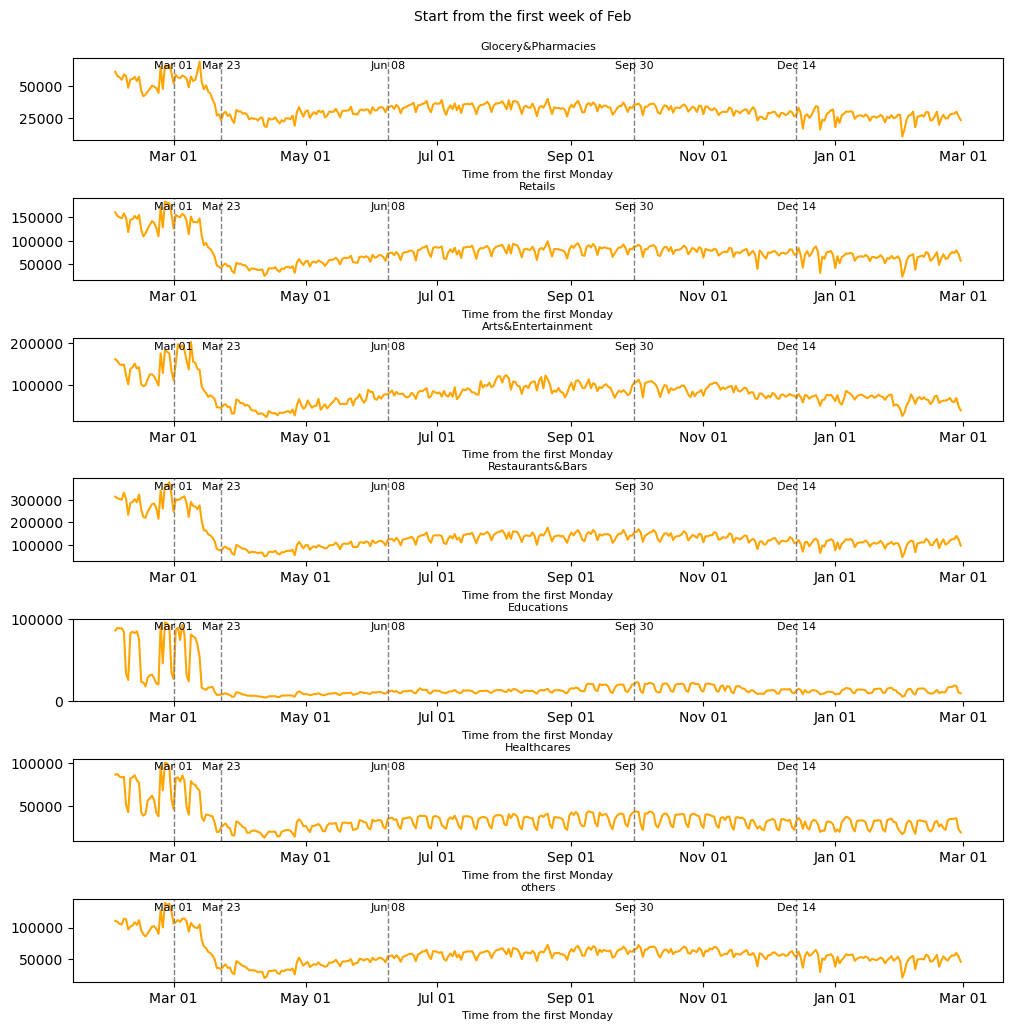

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
# Assuming 'ma' and 'mp' are modules or objects you've defined elsewhere
n_categories = 7 #5
subfolder = 'mobility' if n_categories == 5 else 'mobility_cate7'

fig = plt.figure(figsize=(12, 12))  # Adjusted for 5 rows
fig.suptitle('Start from the first week of Feb', fontsize=10, y=0.92)
gs = gridspec.GridSpec(n_categories, 1, height_ratios=[1]*n_categories, hspace=0.7)  # 5 rows, 1 column

my_color = {2018:'green',2019:'blue',2020:'red', 2021:'orange',2022:'peru'}
start_date = pd.to_datetime('2020-02-03') ### moblity data start from monday to sunday 

dates_to_mark = [
    pd.to_datetime('2020-03-01'),
    pd.to_datetime('2020-03-23'),
    pd.to_datetime('2020-06-08'),
    pd.to_datetime('2020-09-30'),
    pd.to_datetime('2020-12-14')
]


for c in range(n_categories):
    ax = plt.subplot(gs[c])
    Ms_combined = None
    for y in [2020, 2021]:
        # Load and concatenate data for more months if needed
        # Example for February, March, April (existing), extending to more months
        months = ['01', '02'] if y == 2021 else ['02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
        for month in months:# Extend this list with more months as needed
            Ms = ma.h5py_to_4d_array(f'../data/{subfolder}/M_raw_{y}{month}.h5')
#             print(y, month, Ms.shape)
            if Ms_combined is None:
                Ms_combined = Ms
            else:
                Ms_combined = np.concatenate((Ms_combined, Ms), axis=0)
        
        # Assuming the reshaping and summing process remains valid with additional data
    num_days = Ms_combined.shape[0]
    num_weeks = int(num_days/7)
    Ms_reshaped = Ms_combined.reshape(num_weeks, 7, n_categories, 177, 177)  # Adjust dimensions if needed
    Ms_weekly_sums = Ms_reshaped.sum(axis=1)
    flow_out = np.sum(Ms_combined, axis=2)
    flow_all = np.sum(flow_out, axis=2)

    data = flow_all[:, c]
    date_range = pd.date_range(start_date, periods=num_days, freq='D')
    ax.plot(date_range, data, label=f'{y}', c=my_color[y])
    
    for date in dates_to_mark:
        ax.axvline(date, color='gray', linestyle='--', linewidth=1)  # Mark the date with a vertical line
        ax.annotate(date.strftime('%b %d'), xy=(date, 0.9), xycoords=('data', 'axes fraction'),
                    ha='center', va='center', fontsize=8, rotation=0, backgroundcolor='None')
    
    ax.set_title(mp.cluster_name[c], fontsize=8)
    ax.set_xlabel('Time from the first Monday', fontsize=8)
#     ax.set_ylabel('The weekly total flow out', fontsize=8)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
#     ax.axvspan(27.5, 28.5, facecolor='gray', alpha=0.5, label='2nd March (Monday)')
     

# Assuming the legend in the last subplot is still desired
handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='best')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the main 
plt.show()


In [3]:
Ms_flow_out = np.sum(Ms_reshaped, axis=3)
Ms_wksum_out = np.sum(Ms_flow_out,axis=1)
Ms_wksum_out.shape

(56, 7, 177)

In [4]:
df_mod_idx = pd.read_csv('../results/modzcta_zip_counts.csv')
modzcta = df_mod_idx[['MODZCTA','mod_idx']]
df_mod = modzcta.sort_values(by='mod_idx').drop_duplicates()
df_mod = df_mod.reset_index(drop=True)

In [5]:
Lists_all_names = []
new_data = {}

for c in range(n_categories):
    c_name = mp.cluster_name[c]
    wksum = Ms_wksum_out[:, c, :]
    list_names = [c_name + '_' + str(i) for i in range(wksum.shape[0])]  
    Lists_all_names.extend(list_names)
    
    # Append the new data to the dictionary with the appropriate column names
    for n_i, n in enumerate(list_names):
        new_data[n] = wksum[n_i, :]


df_new_data = pd.DataFrame(new_data)
df_mod = pd.concat([df_mod, df_new_data], axis=1)
df_mod['MODZCTA'] = df_mod['MODZCTA'].astype(str)

In [6]:
df_mod.to_csv('../results/outflow_7c_wk_raw.csv',index=False)